In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt

# Đường dẫn file
benchmark_csv = '../data/owasp/expected_results_320.csv' 
sonarqube_csv = '../data/sonarqube/sonarqube_report.csv'  

# Đọc dữ liệu benchmark và sonarqube
benchmark_df = pd.read_csv(benchmark_csv)
sonarqube_df = pd.read_csv(sonarqube_csv)

# Chuẩn hóa benchmark_df
benchmark_df = benchmark_df.rename(columns={'# test name': 'test name', ' category': 'category', ' real vulnerability': 'real vulnerability'})
benchmark_df['category'] = benchmark_df['category'].str.lower()
benchmark_df = benchmark_df.drop(['Benchmark version: 1.2', '2016-06-1'], axis=1)

print("\n🔎 Preview benchmark_df:")
print(benchmark_df.head())


🔎 Preview benchmark_df:
            test name    category  real vulnerability  cwe
0  BenchmarkTest01025  pathtraver                True   22
1  BenchmarkTest01238  pathtraver                True   22
2  BenchmarkTest00528  pathtraver                True   22
3  BenchmarkTest00783  pathtraver                True   22
4  BenchmarkTest02378  pathtraver                True   22


In [2]:
def extract_testcase(component):
    # Tách phần sau dấu ':' nếu có, lấy đường dẫn thật
    path = component.split(':')[-1]
    # Lấy tên file
    filename = path.split('/')[-1]
    # Loại bỏ đuôi .java
    testcase = filename.replace('.java', '')
    return testcase

# Tách testcase từ component của sonarqube
sonarqube_df['testcase'] = sonarqube_df['component'].apply(extract_testcase)

# Ánh xạ rule -> category_sonarqube
rule2category = {
    "java:S2076": "cmdi",
    "java:S2755": "cmdi",
    "java:S2091": "xpath",
    "java:S5131": "xss",
    "java:S5696": "xss",
    "java:S2078": "ldapi",
    "java:S2083": "pathtraver",
    "java:S6096": "pathtraver",
    "java:S3649": "sqli",
    "java:S2092": "securecookie",
    "java:S3330": "securecookie",
    "java:S4347": "weakrand",
    "java:S2119": "weakrand",
    "java:S5547": "crypto",
    "java:S5542": "crypto",
    "java:S4790": "hash",
    "java:S5344": "hash",
}

sonarqube_df['category_sonarqube'] = sonarqube_df['rule'].map(rule2category)

# Lọc chỉ các dòng có category_sonarqube không null (trong 11 CWE)
sonarqube_df = sonarqube_df[sonarqube_df['category_sonarqube'].notna()]

# Gom category_sonarqube theo testcase
sonarqube_grouped = sonarqube_df.groupby('testcase')['category_sonarqube'].apply(set).reset_index()

print("\n🔎 Preview sonarqube_df:")
print(sonarqube_df.head())



🔎 Preview sonarqube_df:
                                     key        rule  severity  \
32  5f349361-b83f-4a67-aeac-27552f35f4a3  java:S5547  CRITICAL   
33  9961631a-7bc7-4ecc-a23a-88d20b0b9ba4  java:S5542  CRITICAL   
43  9dd69ecb-29b1-47e6-9a1a-5f2976d443f8  java:S5542  CRITICAL   
44  e2b96da6-97a9-400b-bc9c-9c8226ad7147  java:S5547  CRITICAL   
48  8c8ee5a4-79eb-46e0-8039-07b858471e66  java:S2119  CRITICAL   

                                            component          project  line  \
32  owasp-benchmark:src/main/java/org/owasp/benchm...  owasp-benchmark    63   
33  owasp-benchmark:src/main/java/org/owasp/benchm...  owasp-benchmark    63   
43  owasp-benchmark:src/main/java/org/owasp/benchm...  owasp-benchmark    51   
44  owasp-benchmark:src/main/java/org/owasp/benchm...  owasp-benchmark    51   
48  owasp-benchmark:src/main/java/org/owasp/benchm...  owasp-benchmark    47   

                                hash  \
32  f1811c9cd1b307e822e92fa8eedcd5c3   
33  f1811c9cd1b30

In [3]:
# Merge benchmark với sonarqube
merged_df = benchmark_df.merge(sonarqube_grouped, left_on='test name', right_on='testcase', how='left')
merged_df['category_sonarqube'] = merged_df['category_sonarqube'].apply(lambda x: x if isinstance(x, set) else set())
merged_df = merged_df.drop(columns=['testcase'])


# Đánh giá TP, FP, FN, TN
def evaluate(row):
    category_benchmark = row['category']
    category_sonarqube_set = row['category_sonarqube']
    real_vuln = row['real vulnerability']

    if real_vuln:  # Benchmark có lỗi
        if category_benchmark in category_sonarqube_set:
            return 'TP'  # sonarqube báo đúng category
        else:
            return 'FN'  # sonarqube không báo
    else:  # Benchmark không lỗi
        if category_benchmark in category_sonarqube_set:
            return 'FP'  # sonarqube báo nhầm
        else:
            return 'TN'  # sonarqube không báo (đúng)

merged_df['Evaluation'] = merged_df.apply(evaluate, axis=1)

print("\n🔎 Preview merged_df:")
print(merged_df.head(10))



🔎 Preview merged_df:
            test name    category  real vulnerability  cwe category_sonarqube  \
0  BenchmarkTest01025  pathtraver                True   22                 {}   
1  BenchmarkTest01238  pathtraver                True   22                 {}   
2  BenchmarkTest00528  pathtraver                True   22                 {}   
3  BenchmarkTest00783  pathtraver                True   22                 {}   
4  BenchmarkTest02378  pathtraver                True   22                 {}   
5  BenchmarkTest01496  pathtraver                True   22                 {}   
6  BenchmarkTest02561  pathtraver                True   22                 {}   
7  BenchmarkTest01111  pathtraver                True   22                 {}   
8  BenchmarkTest00698  pathtraver                True   22                 {}   
9  BenchmarkTest00216  pathtraver                True   22                 {}   

  Evaluation  
0         FN  
1         FN  
2         FN  
3         FN  
4         F

In [4]:
# Xuất file chuẩn multi-tool
sonarqube_output_rows = []
for _, row in merged_df.iterrows():
    sonarqube_output_rows.append({
        'TestCase': row['test name'],
        'CWE': row['category'],
        'Expected': bool(row['real vulnerability']),
        'Detected': row['category'] in row['category_sonarqube']
    })

sonarqube_output_df = pd.DataFrame(sonarqube_output_rows)
sonarqube_output_df.to_csv('../data/sonarqube/sonarqube_results_format.csv', index=False)
print("\n✅ Đã xuất file CSV chuẩn: sonarqube_results_format.csv")

# Tóm tắt kết quả
summary = merged_df['Evaluation'].value_counts().reindex(['TP', 'FP', 'FN', 'TN'], fill_value=0).reset_index()
summary.columns = ['Metric', 'Count']
print("\n📊 Summary TP/FP/FN/TN:")
print(summary)


✅ Đã xuất file CSV chuẩn: sonarqube_results_format.csv

📊 Summary TP/FP/FN/TN:
  Metric  Count
0     TP     30
1     FP      0
2     FN    130
3     TN    160


In [5]:
# Tính chỉ số đánh giá
TP = summary.loc[summary['Metric'] == 'TP', 'Count'].values[0] if 'TP' in summary['Metric'].values else 0
FP = summary.loc[summary['Metric'] == 'FP', 'Count'].values[0] if 'FP' in summary['Metric'].values else 0
FN = summary.loc[summary['Metric'] == 'FN', 'Count'].values[0] if 'FN' in summary['Metric'].values else 0
TN = summary.loc[summary['Metric'] == 'TN', 'Count'].values[0] if 'TN' in summary['Metric'].values else 0

# Tính các chỉ số
def metrics_paper(tp, fp, fn, tn):
    rec = tp / (tp + fn) if tp + fn else 0.0
    prec = tp / (tp + fp) if tp + fp else 0.0
    fpr = fp / (tn + fp) if tn + fp else 0.0

    # F–scores (β = 1, 0.5, 1.5)
    fbeta = lambda b: (1 + b**2) * prec * rec / (b**2 * prec + rec) if (prec + rec) else 0.0
    f1, f05, f15 = fbeta(1), fbeta(0.5), fbeta(1.5)

    # Markedness (TPR+TNR centered)
    denom_mark = math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    mark = ((tp * tn) - (fp * fn)) / denom_mark if denom_mark else 0.0
    
    # Informedness (Youden J)
    inf = rec - fpr

    results = {
        "Rec":  rec,
        "FPR":  fpr,
        "Prec": prec,
        "F-Mes": f1,
        "F0.5": f05,
        "F1.5": f15,
        "Mark": mark,
        "Inf":  inf,
    }

    print("\n=== KẾT QUẢ ===")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")

    return results

metrics = metrics_paper(TP, FP, FN, TN)


=== KẾT QUẢ ===
Rec: 0.1875
FPR: 0.0000
Prec: 1.0000
F-Mes: 0.3158
F0.5: 0.5357
F1.5: 0.2500
Mark: 0.3216
Inf: 0.1875


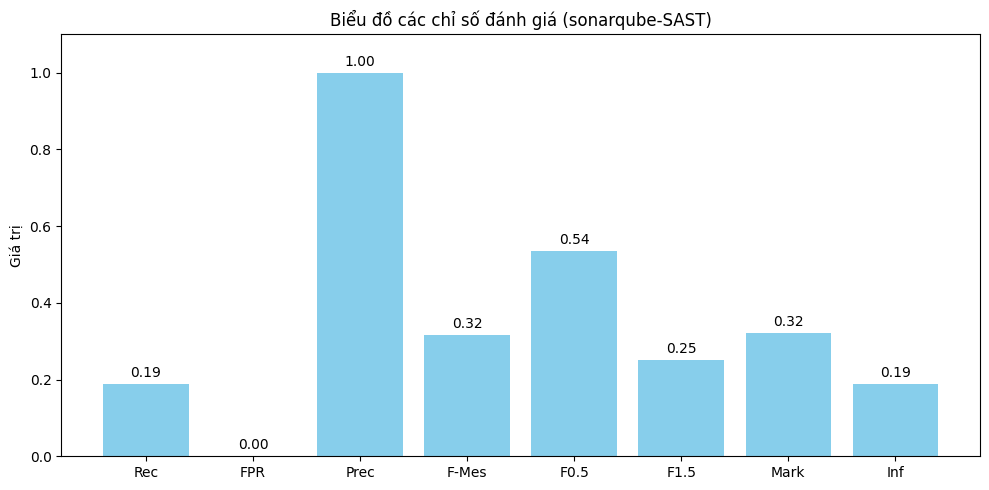

In [6]:
# Vẽ biểu đồ
labels, values = list(metrics.keys()), list(metrics.values())
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, values, color='skyblue')
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
ax.set_ylim(0, 1.1)
ax.set_ylabel('Giá trị')
ax.set_title('Biểu đồ các chỉ số đánh giá (sonarqube-SAST)')
plt.tight_layout()
plt.show()